# Image classification code

This code does the following steps:
1. Split data into test and training images
2. Performs PCA analysis on the whole dataset to work with less dimensions of the images
3. Fits a neural network classifier
4. Fits an AdaBoost classifier

**1. Split data into training and test**

In order for this code to work, the file structure must be as follows:

* root
    * main.py
    * images
        * 1.jpg
        * 2.jpg
        * ...
        * 200.jpg
        * all_images.csv



All images (both training and test) will be in the same folder. the `.csv` file will have the following format:

![csvExample](readmeHelp/csvExample.png)

Where `id`is the number of the `.jpg` file and `label` is the class of each picture. This file will be used to randomly select training and testing sets

**2. Perform PCA analysis**

Training images have a large number of features and there may not be too much variance between them. PCA reduction is very helpful as it allows us to reduce the number of features by finding underlying variables that explain most of the dataset's variance.

**3 & 4. Build NN and AdaBoost Classifiers**

Two different types of classifiers are built in order to compare them and find the one that yields the best performance. In both cases, several different parameters are tested and compared to each other to find the ones that best fit our objective.

# Libraries

In [1]:
# Generic
import pandas as pd
import numpy as np
from tqdm import tqdm # for progress bar in loops

# For train/test split
from sklearn.utils import shuffle # Shuffling the names of the image files in excel
from sklearn.model_selection import train_test_split # Spliting training and testing dataset

# Importing images
import matplotlib.pyplot as plt # importing images
from skimage.color import rgb2gray # transforming color images into grayscale

## Images are split into train and test batches

In [2]:
images_data = pd.read_csv('./images/all_images.csv', index_col = False)
images_data = shuffle(images_data, random_state = 0)

In [3]:
X = images_data["id"]
y = images_data["label"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

In [5]:
X_train_files = np.array(X_train)
X_test_files = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

## Images are loaded

Example image

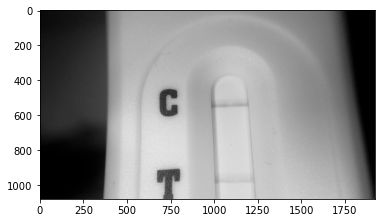

In [6]:
# Image is loaded and transformed into grayscale
url = "./images/1.jpg"
im_byn = rgb2gray(plt.imread(url,  format='jpeg'))

# Variables necesarias para los ajustes de dimensiones
height, width = im_byn.shape 
array_length = height * width

# Ajuste de dimensiones para que cada imagen sea una fila en la tabla
im = np.reshape(im_byn, array_length) 

# Se muestra la imagen
plt.imshow(im_byn, cmap='Greys_r')
#plt.imshow(np.reshape(im, (heigth, witdh)), cmap='Greys_r')

Function to load image in correct dimensions

In [7]:
def loadImageAsRow(url):
    im_byn = rgb2gray(plt.imread(url,  format='jpeg'))
    height, width = im_byn.shape 
    array_length = height * width
    im = np.reshape(im_byn, array_length) 
    return im

In [8]:
X_train = np.zeros((len(X_train_files), array_length))
for i in tqdm(range(len(X_train_files))):
    url = './images/'+ str(X_train_files[i])+'.jpg'
    im = loadImageAsRow(url)
    X_train[i, :] = im

100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:23<00:00,  7.20it/s]


In [9]:
X_test = np.zeros((len(X_test_files), array_length))
for i in tqdm(range(len(X_test_files))):
    url = './images/'+ str(X_test_files[i])+'.jpg'
    im = loadImageAsRow(url)
    X_test[i, :] = im

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.13it/s]


## PCA analysis to reduce number of dimensions

### Normalization of data

`mean` and `std` are obtained from full dataset

In [10]:
X_all = np.concatenate((X_train, X_test), axis = 0)

In [11]:
X_all.shape

(210, 2073600)

In [12]:
mean = np.sum(X_all, axis = 0) / X_all.shape[0]
std = np.std(X_all, axis = 0)

Implement normalization function to train and test

In [13]:
def normalize(X, mean, std):
    """Normalizes a given array X by columns 
    with the mean and std"""
    X_out = np.zeros(X.shape)
    X_out = (X - mean)/std
    return X_out 

In [14]:
X_train = normalize(X_train, mean, std)
X_test = normalize(X_test, mean, std)

### PCA 

In [15]:
from sklearn.decomposition import PCA

In [16]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

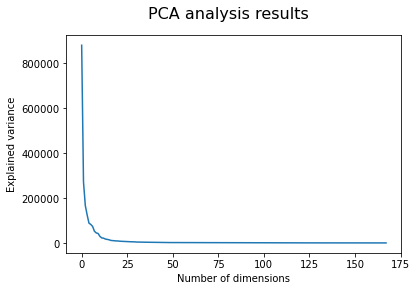

In [17]:
plt.plot(pca.explained_variance_)
plt.ylabel('Explained variance')
plt.xlabel('Number of dimensions')
plt.suptitle('PCA analysis results', fontsize=16)
plt.show()

In [18]:
## Relevant features are selected before applying neural network
X_train = X_train_pca[:,0:20]
X_test = X_test_pca[:,0:20]
X_train.shape

(168, 20)

## Neural Network


Regular neural network with arbitrary parameters is fitted

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import hamming_loss

In [20]:
model_nNetwork = MLPClassifier(random_state=1, max_iter=1000, alpha = 1.2, activation = 'relu', learning_rate = 'adaptive', hidden_layer_sizes=(20,20) )
model_nNetwork.fit(X_train, y_train)

MLPClassifier(alpha=1.2, hidden_layer_sizes=(20, 20), learning_rate='adaptive',
              max_iter=1000, random_state=1)

In [21]:
y_pred_train = model_nNetwork.predict(X_train)
error = hamming_loss(y_train, y_pred_train)
print('The training error is: ' + str(error) + '.')

The training error is: 0.02976190476190476.


In [22]:
y_pred_test = model_nNetwork.predict(X_test)
error = hamming_loss(y_test, y_pred_test)
print('The testing error is: ' + str(error) + '.')

The testing error is: 0.11904761904761904.


In [23]:
predicted_accuracy = 1- error
predicted_accuracy

0.8809523809523809

## Neural network - Random Search

Several different parameter combinations will be tried in order to find the best possible model when using neural networks

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import hamming_loss

In [25]:
# All possible parameters are stored in a dictionary
activation_functions = ['logistic', 'tanh', 'relu', 'identity']
solvers = ['adam','lbfgs', 'sgd']
learning_rates = ['adaptive', 'invscaling']
alphas = np.linspace(start=0.1, stop =3, num = 10).tolist()
distributions = {'activation':('logistic', 'tanh', 'relu', 'identity'), 'solver':('adam','lbfgs', 'sgd'), 'learning_rate':('adaptive', 'invscaling'), 'alpha':alphas}

In [26]:
# Classifier is built
neural_NN = MLPClassifier(max_iter=2000, random_state = 1)

In [27]:
#clf = GridSearchCV(neural_NN, parameters)
clf = RandomizedSearchCV(neural_NN, distributions)
clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=MLPClassifier(max_iter=2000, random_state=1),
                   param_distributions={'activation': ('logistic', 'tanh',
                                                       'relu', 'identity'),
                                        'alpha': [0.1, 0.42222222222222217,
                                                  0.7444444444444444,
                                                  1.0666666666666667,
                                                  1.3888888888888888,
                                                  1.711111111111111,
                                                  2.033333333333333,
                                                  2.3555555555555556,
                                                  2.6777777777777776, 3.0],
                                        'learning_rate': ('adaptive',
                                                          'invscaling'),
                                        'solver': ('adam', 'l

The best possible model parameters found are:

In [28]:
clf.best_params_

{'solver': 'lbfgs',
 'learning_rate': 'invscaling',
 'alpha': 0.1,
 'activation': 'tanh'}

The model results will be shown below:

In [29]:
y_pred_train = clf.predict(X_train)
error = hamming_loss(y_train, y_pred_train)
print('The training error is: ' + str(error) + '.')

The training error is: 0.0.


In [30]:
y_pred_test = clf.predict(X_test)
error = hamming_loss(y_test, y_pred_test)
print('The testing error is: ' + str(error) + '.')

The testing error is: 0.0.


Testing accuracy is 100%. This is likely due to overfitting and not a realistic expectation. In order to fully trust this, it would be advisable to use a greater number of pictures for the training of the neural network

## AdaBoost Classifier

In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

Parameters for the different classifiers to be trained and compared

In [32]:
n_max = 10  # used as an exponent in the indices parameter
indices = 2**np.array(range(0,n_max)) # array representing the amount of weak classifiers: 2^1, 2^2, 2^3....2^n_max
depth = [10, 20, 50, 100] # Depth of the decision tree classifier

Results for each of the parameter combinations will be stored in a dataframe for later study:

In [33]:
rows_pollution_index = []
columns = ['TreeDepth', 'NumTrees', 'TrainAcc', 'TestAcc']

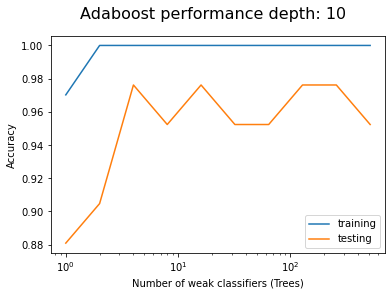

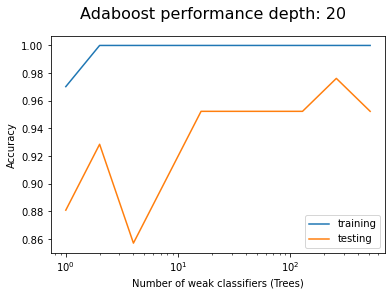

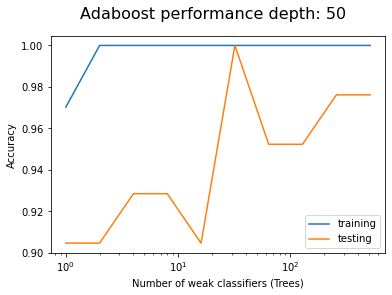

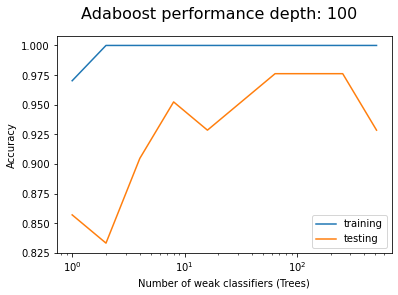

In [34]:
for dep in depth:
    #print("\n\n==================================")
    #print("\nDepth: " + str(dep))
    tree = DecisionTreeClassifier(max_depth= dep, min_samples_split = 3, min_samples_leaf = 2)
    Acc_Train = []
    Acc_Test = []
    
    for i in range(n_max):
        clf = AdaBoostClassifier(n_estimators=indices[i], base_estimator=tree).fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        
        # Accuracy calculated and appended to array for later plotting
        accuracy_trn_value = accuracy_score(y_train, y_train_pred)
        accuracy_tst_value = accuracy_score(y_test, y_test_pred)
        Acc_Train.append(accuracy_trn_value)
        Acc_Test.append(accuracy_tst_value)
        
        #print("\nNumber of Weak Classifiers: " + str(indices[i]))
        #print("Training accuracy: " + str(accuracy_trn_value))
        #print("Testing accuracy: " + str(accuracy_tst_value))
        
        # Appended to list to be later transformed into df
        rows_pollution_index.append(dict(zip(columns,[dep, indices[i], accuracy_trn_value, accuracy_tst_value])))
    
    
    plt.figure()
    plt.semilogx(indices,Acc_Train, label = "training")
    plt.semilogx(indices,Acc_Test, label = "testing")
    plt.suptitle("Adaboost performance depth: " + str(dep), fontsize=16)
    plt.ylabel('Accuracy')
    plt.xlabel('Number of weak classifiers (Trees)')
    plt.legend()

Dataset with all results is built

In [35]:
df_results = pd.DataFrame(rows_pollution_index)

Best training performance is found

In [36]:
np.argmax(df_results["TestAcc"])

25

Model is represented below

In [37]:
df_results.iloc[3,]

TreeDepth    10.000000
NumTrees      8.000000
TrainAcc      1.000000
TestAcc       0.952381
Name: 3, dtype: float64

**Testing accuracy: 95%**